# Convolutional neural network framework

In [132]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import pandas as pd
sns.set_style("darkgrid")



# Keras documentation can be found on keras.io:
import keras
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Jens csv kode

In [133]:
def import_and_pad_csvs(folder_path):
    # List all CSV files in the given folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files_sorted = np.sort(np.array(csv_files))
    #print(csv_files_sorted)
    # Initialize an empty list to store the data arrays
    data_arrays = []

    indecies = np.zeros_like(csv_files_sorted, dtype=int)
    for i in range(len(csv_files_sorted)):
        indecies[i] = int(csv_files_sorted[i][:-6])
        #print(type(indecies[i]))
    #print(csv_files_sorted, indecies)
        
    
    # Iterate over the CSV files and read them into numpy arrays
    for file in csv_files_sorted:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path).values
        data_arrays.append(data)
    
    # Find the maximum number of rows and columns among all CSV files
    max_rows = max(array.shape[0] for array in data_arrays)
    max_cols = max(array.shape[1] for array in data_arrays)
    
    # Find the index of the largest array (by number of elements)
    largest_array_index = max(range(len(data_arrays)), key=lambda i: data_arrays[i].shape[0] * data_arrays[i].shape[1])
    
    print(f"Index of the largest initial array: {largest_array_index}")
    
    # Initialize a list to store padded arrays
    padded_arrays = np.zeros((max_rows, max_cols))
    center = max(int(max_rows / 2), int(max_cols / 2))
    max_size = 64
    combined_array = np.zeros((len(data_arrays), max_size, max_size))
    # Pad each array with zeros to match the maximum size
    nr = 0
    for array in data_arrays:
        #print(array.shape)
        #print(center - int(np.floor(array.shape[0] / 2)), center + int(np.ceil(array.shape[1] / 2)))
        padded_array = np.zeros((max_rows, max_cols)) + 4000
        #print(padded_array[center - int(np.floor(array.shape[0] / 2)) :center + int(np.ceil(array.shape[0]/2)),
                     #center - int(np.floor(array.shape[1] / 2)) :center + int(np.ceil(array.shape[1]/2))])
        padded_array[center - int(np.floor(array.shape[0] / 2)) :center + int(np.ceil(array.shape[0]/2)),
                     center - int(np.floor(array.shape[1] / 2)) :center + int(np.ceil(array.shape[1]/2))] = array
        combined_array[nr] = padded_array[center - int(max_size/2): center + int(max_size/2), center - int(max_size/2): center + int(max_size/2)]
        #combined_array = np.concatenate((combined_array, np.array([padded_arrays])), axis=0)
        #padded_arrays.append(padded_array)
        nr += 1
    

    # Stack all padded arrays along a new dimension to create the final array
    #combined_array = np.stack(padded_arrays, axis=0)
    
    
    return combined_array, indecies

def import_rescaled_csv(folder_path):
    # List all CSV files in the given folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files_sorted = np.sort(np.array(csv_files))
    #print(csv_files_sorted)
    # Initialize an empty list to store the data arrays
    data_arrays = []

    indecies = np.zeros_like(csv_files_sorted, dtype=int)
    for i in range(len(csv_files_sorted)):
        indecies[i] = int(csv_files_sorted[i][:-6])
        #print(type(indecies[i]))
    #print(csv_files_sorted, indecies)
        
    
    # Iterate over the CSV files and read them into numpy arrays
    for file in csv_files_sorted:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path, header=None).values
        data_arrays.append(data)

    return data_arrays, indecies
    
meta_data = pd.read_csv('cluster_meta.csv')
print(meta_data.head())

def load_data(folder_path,meta_data):
    data = []
    for file in meta_data['cluster']:
        file = file + '.csv'
        file_path = os.path.join(folder_path,file)
        cluster = pd.read_csv(file_path,header=None).values
        cluster = cluster.flatten()
        cluster = np.append(cluster, meta_data[meta_data['cluster'] == file[:-4]][['y', 'x', 'E', 'size']].values.flatten())
        data.append(cluster)
    combined_array = np.stack(data,axis=0)
    print('shape of combined array: ')
    print(combined_array.shape)
    return combined_array


meta_scaler = MinMaxScaler()
meta_data_values = meta_scaler.fit_transform(meta_data[['y', 'x', 'E', 'size']])
print(meta_data.head())

   Unnamed: 0   cluster     y     x          E   size
0           0  004580_A   9.0  26.0   715232.0  108.0
1           1  011701_G  15.0  17.0  1184202.0  179.0
2           2  003882_A   3.0   3.0    31156.0    6.0
3           3  009717_G   7.0  62.0  1423016.0  245.0
4           4  005590_A  32.0  31.0  1014772.0  169.0
   Unnamed: 0   cluster     y     x          E   size
0           0  004580_A   9.0  26.0   715232.0  108.0
1           1  011701_G  15.0  17.0  1184202.0  179.0
2           2  003882_A   3.0   3.0    31156.0    6.0
3           3  009717_G   7.0  62.0  1423016.0  245.0
4           4  005590_A  32.0  31.0  1014772.0  169.0


# Import Data

In [134]:
a = np.array(['123456', '12345', '1235312'])

print(136/8)

17.0


31 31


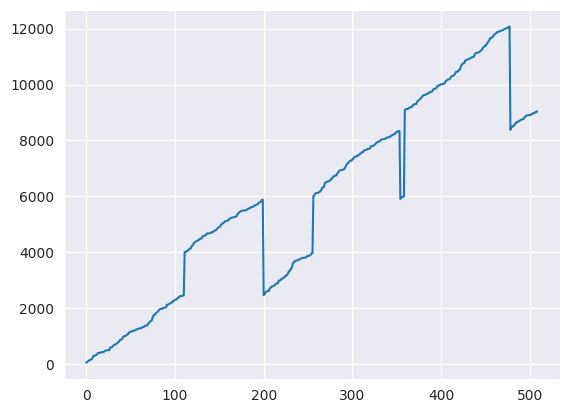

3936 3936


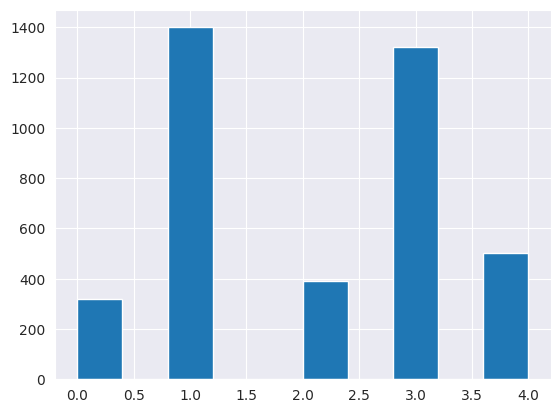

[3 3 3 ... 1 1 1]
<class 'numpy.ndarray'> [2 2 2 ... 0 0 0]


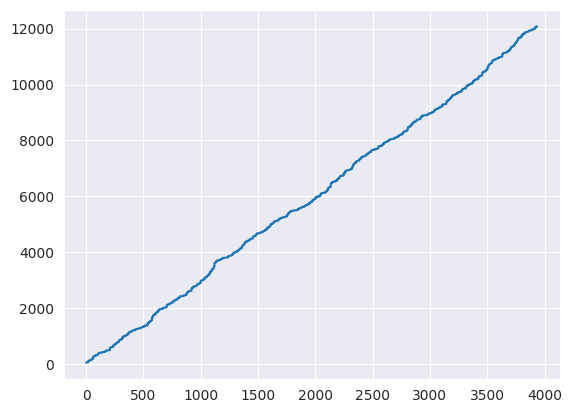

[   61    61    61 ... 12076 12076 12076] [2 2 2 ... 0 0 0]


In [135]:
data_raw, index = import_rescaled_csv('clusters_colour_rotations_rescaled/')
#mata_data_raw = load_data('clusters_colour_rotations_rescaled/', meta_data)
labels_raw = [np.load('./labels/'+x) for x in os.listdir('./labels/') if x.endswith('.npy')]
print(len(labels_raw[8][0]), len(labels_raw[8][1]))

#labels_raw_sorted = np.sort(np.array(labels_raw))
label_dict = {}
value_array = []
for values in labels_raw:
    for value,ind in zip(values[0],values[1]):
        value_array.append(value)
        #print(value)
        label_dict[value] = ind
    #print(len(value[1].tolist()), len(value[0].tolist()))
#label_dict = [item for sublist in label for item in sublist]
#ind = [item for sublist in ind for item in sublist]
#ind_repeat = np.repeat(ind, 8)
#ind_sort_arg = np.argsort(ind_repeat)
plt.plot(value_array)
plt.show()

label = [label_dict[i_] for i_ in index]
print(len(label), len(index))
#mask = [index != ind]
#print(print(index, ind))
#plt.plot(index - ind)
#plt.show()

#index_remove = np.array([31, 74, 116, 165, 170, 193, 214, 280, 314, 401, 413, 470, 499])
#label = np.delete(label, index_remove)


#print(len(label)*8)
#print(data_raw.shape)

plt.hist(label)
plt.show()
label = np.array(label, dtype=int)
print(label)
#label_sorted = label[ind_sort_arg]



# Remove all reading erros, multiple objects, and others.
data_raw = np.array(data_raw)
data_raw = data_raw[(label != 4) * (label != 0)]
label = label[(label != 4) * (label != 0)] - 1

#print(data_raw.shape)
# the data, split between train and testval sets

### since the data is limited in amount, we will use crossvalidation to only have to split the data in train and test, and use the crossvalidation for the validation

print(type(label), label)

train_images, testval_images, train_labels, testval_labels = train_test_split(data_raw, label, test_size=0.2, random_state=13052020)

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
val_images, test_images, val_labels, test_labels = train_test_split(testval_images, testval_labels, test_size=0.5, random_state=13052020)

plt.plot(index)
plt.show()
print(index, label)


In [125]:
type(data_raw)

numpy.ndarray

# Normelize Data

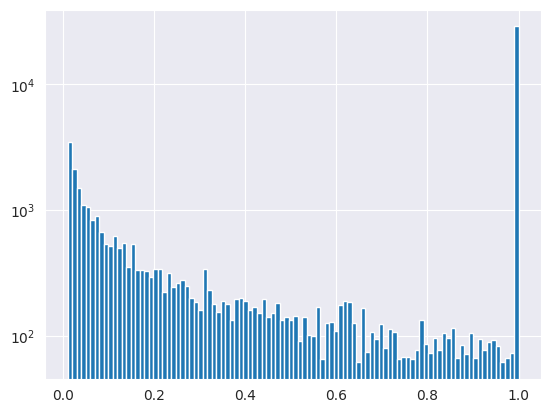

(64, 64)


In [136]:
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, RobustScaler

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)


#scaler = MinMaxScaler()
#scaler = QuantileTransformer()
scaler = RobustScaler()
#sorted_images = np.sort(train_images.reshape(-1, 1))
#scaler.fit(sorted_images)
scaler.fit(train_images.reshape(-1, 1))
train_images = scaler.transform(train_images.reshape(-1, 1)).reshape(train_images.shape)
val_images = scaler.transform(val_images.reshape(-1, 1)).reshape(val_images.shape)
#test_images = scaler.transform(test_images.reshape(-1, 1)).reshape(test_images.shape)

plt.hist(train_images.flatten(), bins=100, range=(0.01, 1))
plt.yscale('log')
plt.show()
# Standardize pixel distribution to have zero mean and unit variance
#train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
#val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))
# Alternative: quantile normalization
# train_images = quantile_transform(train_images, output_distribution='normal', copy=True)
# val_images = quantile_transform(val_images, output_distribution='normal', copy=True)


print(np.shape(data_raw[0]))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 64, 64 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)
#test_images = val_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 3 # number of classes
train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)
#test_labels = keras.utils.to_categorical(test_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
# test_images = quantile_transform(test_images, output_distribution='normal', copy=True)
#test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# Setup CNN

In [139]:
def compile_CNN_model(model_type=Sequential(), layer_types=[Conv2D, MaxPooling2D, Flatten, Dropout, Dense], hyperperams_list=np.zeros((7,3)), img_rows=28, img_cols=28, num_classes=10):
    model = model_type  # Network model type

    N_layers = len(layer_types)
    layers = np.array([])
    for i in range(layer_types):
        if layer_types[i] == 0:
            layers = np.append(layers, Conv2D)
            hyp_peram = {'filters': hyperperams_list[i, 0], 'kernel_size': hyperperams_list[i, 1], 'strides': hyperperams_list[i, 2], 'activation': 'relu', 'input_shape': (img_rows, img_cols, 1)}
            hyperperams = np.append(hyperperams, hyp_peram)

        if layer_types[i] == 1:
            layers = np.append(layers, MaxPooling2D)
            hyp_peram = {'pool_size': hyperperams_list[i, 0], 'strides': hyperperams_list[i, 1]}
            hyperperams = np.append(hyperperams, hyp_peram)
        if layer_types[i] == 2:
            layers = np.append(layers, Flatten)
            hyp_peram = {}
            hyperperams = np.append(hyperperams, hyp_peram)
        if layer_types[i] == 3:
            layers = np.append(layers, Dropout)
            hyp_peram = {'rate': hyperperams_list[i, 0]}
            hyperperams = np.append(hyperperams, hyp_peram)

        if layer_types[i] == 4:
            layers = np.append(layers, Dense)
            hyp_peram = {'units': hyperperams_list[i, 0], 'activation': 'relu'}
            
    
    for i in range(N_layers):
        model.add(layers[i](**layer_hyperperams[i]))

    
    # specify optimization strategy and metric used for monitoring during training
    model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

    return model



model = Sequential()  # Network type is Sequential

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

# specify optimization strategy and metric used for monitoring during training
model.compile(loss=CategoricalCrossentropy(),
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])


def create_tf_model_CNN(trial):
    N_conv_layers = trial.suggest_int('N_conv_layers', 1, 3)
    N_dense_layers = trial.suggest_int('N_dense_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    model = Sequential()  # Network type is Sequential
    for i in range(N_conv_layers):
        model.add(Conv2D(filters=2**trial.suggest_int('conv_filter_exp'+str(i), 3, 7),
                         kernel_size=trial.suggest_int('conv_kernel_size'+str(i), 2, 5),
                         strides=1,
                         padding='same',
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    for i in range(N_dense_layers - 1):
        model.add(Dense(units=2**trial.suggest_int('dense_units_exp'+str(i), 3, 5), activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    #model.summary()
    return model

def create_tf_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = "Adam"#trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["weight_decay"] = trial.suggest_float("rmsprop_weight_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-7, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


def objective(trial, X_train, Y_train, X_test, Y_test):
    # Build model and optimizer.
    model = create_tf_model_CNN(trial)
    optimizer = create_tf_optimizer(trial)
    model.compile(optimizer, loss=CategoricalCrossentropy())
    # Fit the model to the data
    model.fit(x=X_train, y = Y_train, epochs=30, validation_data=(X_test, Y_test), verbose=0)
    # Find the accuracy
    cce = CategoricalCrossentropy()
    accuracy = cce(Y_test, model(X_test))
    # Return accuracy
    return accuracy






Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_243 (Conv2D)             │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_243               │ (None, 32, 32, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_244 (Conv2D)             │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_244               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_117 (Flatten)           │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,483 (8.07 MB)

 Trainable params: 2,116,483 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

## HYPER OPT der virker

In [140]:
import optuna
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_images, train_labels, val_images, val_labels), n_trials=20)
# trial = study.best_trial



[I 2024-06-05 13:28:30,658] A new study created in memory with name: no-name-d742c811-cd0a-4008-83be-7d27b02e89ef
[I 2024-06-05 13:31:49,212] Trial 0 finished with value: 12.163803100585938 and parameters: {'N_conv_layers': 1, 'N_dense_layers': 2, 'dropout_rate': 0.46680917457531773, 'conv_filter_exp0': 7, 'conv_kernel_size0': 5, 'dense_units_exp0': 4, 'adam_learning_rate': 3.008928551316865e-07}. Best is trial 0 with value: 12.163803100585938.
[I 2024-06-05 13:35:16,009] Trial 1 finished with value: 1.8079994916915894 and parameters: {'N_conv_layers': 1, 'N_dense_layers': 3, 'dropout_rate': 0.03126126904315535, 'conv_filter_exp0': 7, 'conv_kernel_size0': 5, 'dense_units_exp0': 4, 'dense_units_exp1': 5, 'adam_learning_rate': 0.00326364002954828}. Best is trial 1 with value: 1.8079994916915894.
[I 2024-06-05 13:37:17,533] Trial 2 finished with value: 0.6616171002388 and parameters: {'N_conv_layers': 3, 'N_dense_layers': 3, 'dropout_rate': 0.2395585831853571, 'conv_filter_exp0': 5, 'conv

In [129]:
study.best_params

{'N_conv_layers': 3,
 'N_dense_layers': 3,
 'dropout_rate': 0.05417195074720438,
 'conv_filter_exp0': 3,
 'conv_kernel_size0': 5,
 'conv_filter_exp1': 6,
 'conv_kernel_size1': 3,
 'conv_filter_exp2': 5,
 'conv_kernel_size2': 2,
 'dense_units_exp0': 3,
 'dense_units_exp1': 5,
 'adam_learning_rate': 0.001031416137647467}

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - categorical_accuracy: 0.4289 - loss: 8.8132 - val_categorical_accuracy: 0.4341 - val_loss: 1.2822
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - categorical_accuracy: 0.4268 - loss: 1.0575 - val_categorical_accuracy: 0.4341 - val_loss: 1.1822
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - categorical_accuracy: 0.4235 - loss: 1.0271 - val_categorical_accuracy: 0.4341 - val_loss: 1.1695
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - categorical_accuracy: 0.4297 - loss: 1.0216 - val_categorical_accuracy: 0.4341 - val_loss: 1.1491
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - categorical_accuracy: 0.4354 - loss: 1.0014 - val_categorical_accuracy: 0.4502 - val_loss: 1.1452
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - categorical_accuracy: 0.4798 - loss: 1.0015 - val_categorical_accuracy: 0.4437 - val_loss: 1.1601
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - categorical_accuracy: 0.4414 - loss: 1.02

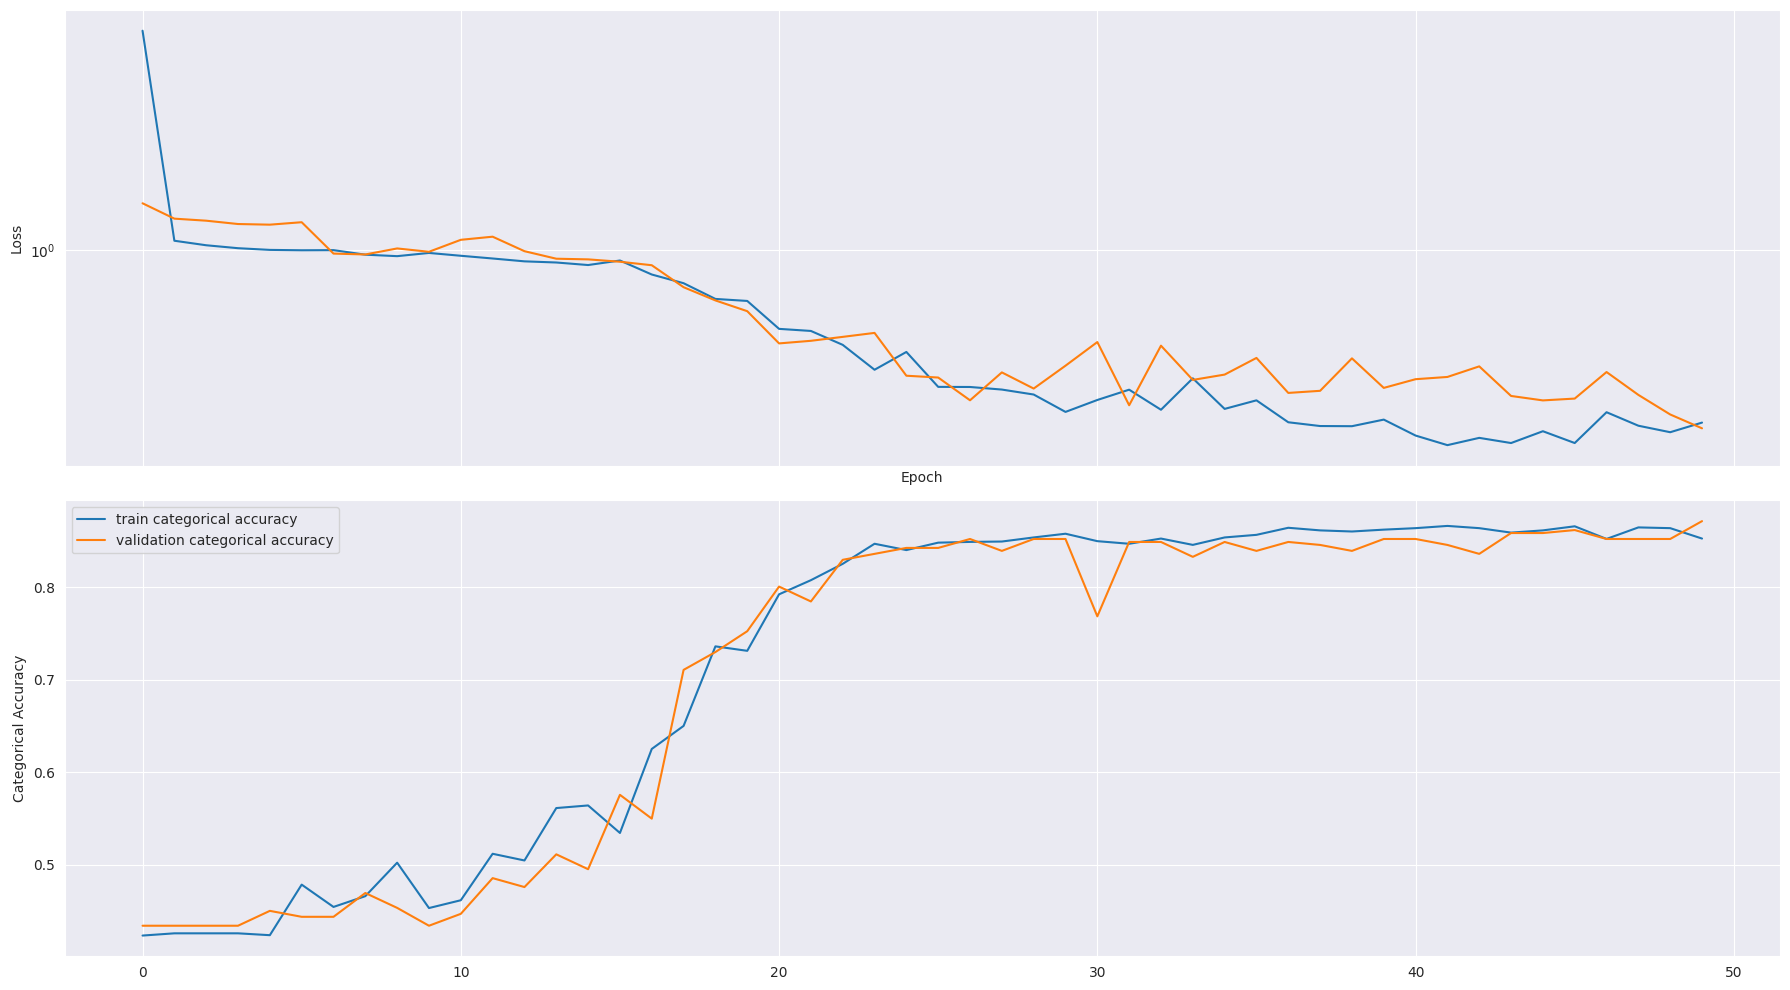

In [138]:
trial = study.best_trial
tf_model = create_tf_model_CNN(trial)
tf_optimizer = create_tf_optimizer(trial)
tf_model.compile(optimizer=tf_optimizer, loss=CategoricalCrossentropy(), metrics=['categorical_accuracy'])
history = tf_model.fit(x=train_images, y=train_labels, epochs=50, validation_data=(val_images, val_labels), verbose=1)
fig, ax = plt.subplots(nrows=2, sharex=True)


fig.set_size_inches((18, 10))
ax[0].set_yscale('log')
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[1].plot(history.history['categorical_accuracy'], label='train categorical accuracy')
ax[1].plot(history.history['val_categorical_accuracy'], label='validation categorical accuracy')

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Categorical Accuracy')
fig.tight_layout()
plt.legend()
plt.show()

NameError: name 'history' is not defined

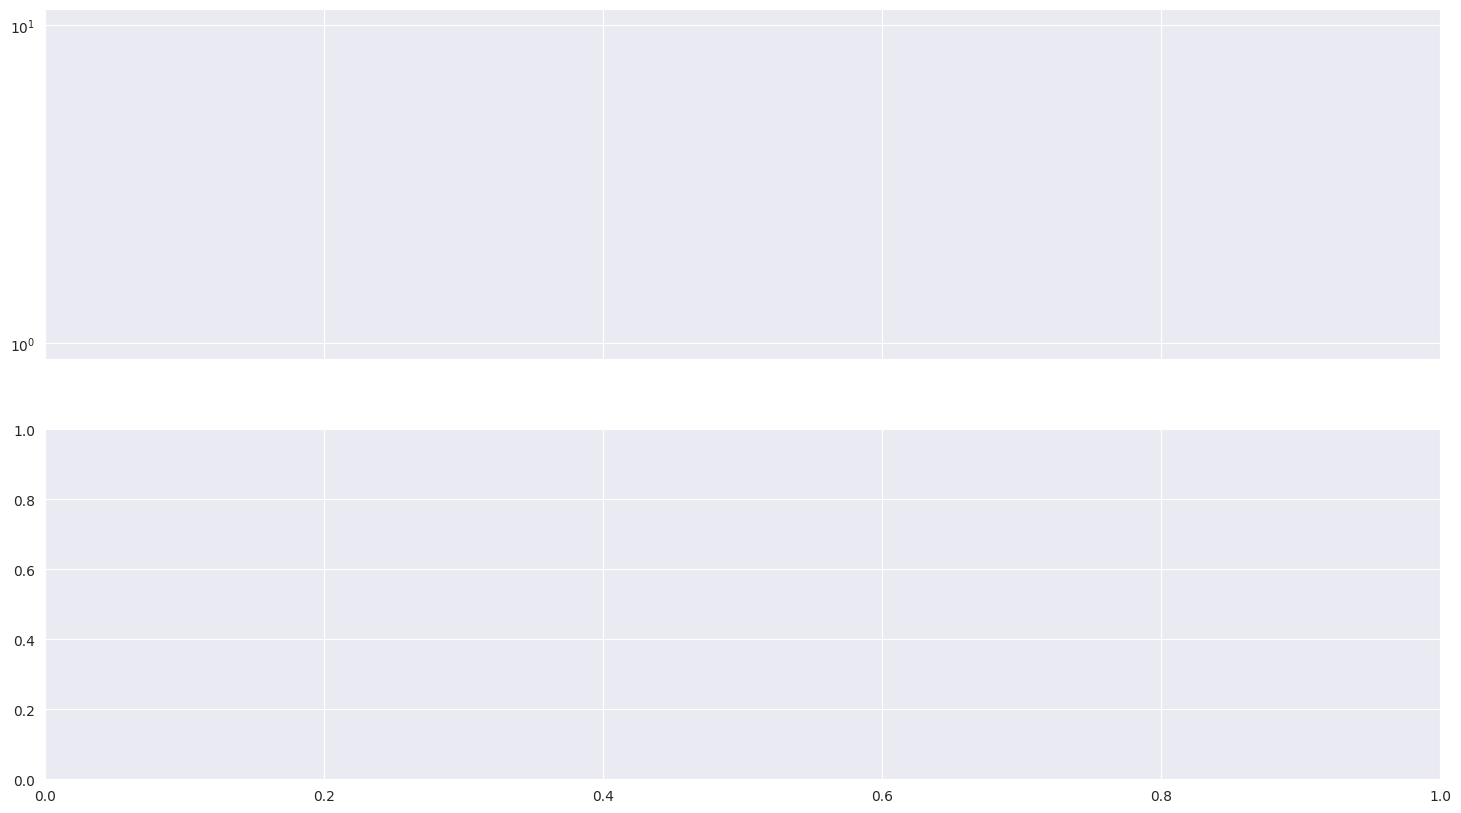

# Train CNN

In [147]:
# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=256,
                    epochs=5000,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Epoch 1/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - categorical_accuracy: 0.3194 - loss: 191.0000 - val_categorical_accuracy: 0.2166 - val_loss: 120.4567
Epoch 2/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - categorical_accuracy: 0.3416 - loss: 177.2306 - val_categorical_accuracy: 0.2484 - val_loss: 106.3861
Epoch 3/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - categorical_accuracy: 0.3534 - loss: 171.0882 - val_categorical_accuracy: 0.2803 - val_loss: 94.4242
Epoch 4/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - categorical_accuracy: 0.3920 - loss: 157.8262 - val_categorical_accuracy: 0.3344 - val_loss: 84.9637
Epoch 5/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - categorical_accuracy: 0.4172 - loss: 141.4201 - val_categorical_accuracy: 0.4140 - val_loss: 77.1096
Epoch 6/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - categorical_accuracy: 0.3987 - loss: 142.4125 - val_categorical_accuracy: 0.4777 - val_loss: 70.7760
Epoch 7/5000
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - 

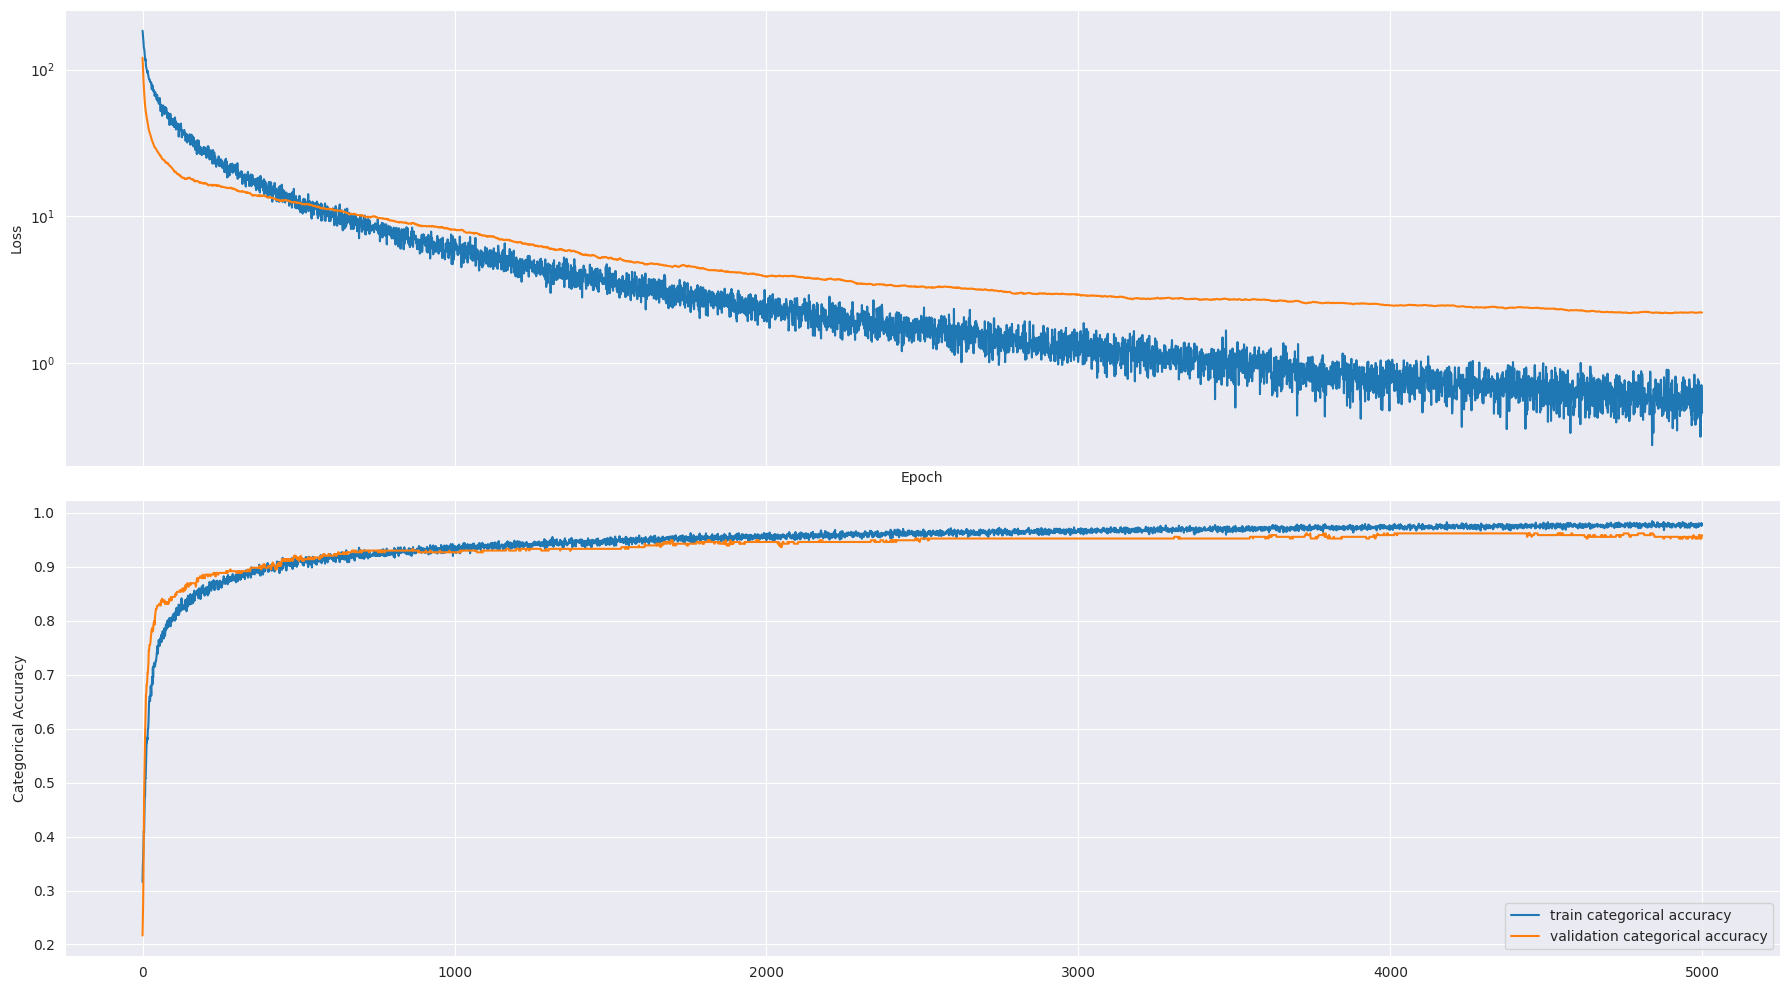

In [156]:
fig, ax = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches((18, 10))
ax[0].set_yscale('log')
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[1].plot(history.history['categorical_accuracy'], label='train categorical accuracy')
ax[1].plot(history.history['val_categorical_accuracy'], label='validation categorical accuracy')

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Categorical Accuracy')
fig.tight_layout()
plt.legend()
plt.show()

# Save the model

In [158]:
model.save_weights('categorical_CNN_2_6.weights.h5')

# Hyperperameter optimization

In [ ]:
import optuna


def objective(trial):
    layer_numbers = trial.suggest_int('layer_numbers', 1, 10)
    peram = {'model_type': Sequential(),
                'layer_types': [trail.sugeest_int('layer_types', 0, 4, layer_numbers) for i in range(layer_numbers)],
                'hyperperams_list': np.zeros((7,3)),
                'img_rows': 28,
                'img_cols': 28,
                'num_classes': 10
                }
        
    

def objective_exmaple(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1),
        'objective': 'binary:logistic'
    }
    bst = XGBClassifier(**param)
    bst.fit(df_train_X_clf_final, df_train_Y_clf_final)
    preds = bst.predict_proba(df_valid_X_clf_final)
    log_log_clf_XGB = log_loss(df_valid_Y_clf_final, preds)
    return log_log_clf_XGB

study_example = optuna.create_study(direction='minimize')
study_example.optimize(objective_example, n_trials=20, show_progress_bar=True)